# Optimizing EKG Circuit

Created by Thomas Jagielski and Arwen Sadler

In [59]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Question:

For this project we were interested in modeling the EKG circuit we built in Introduction to Sensors, Instrumentation and Measurements (ISIM).  The question we addressed was, how does this circuit respond with changes in RC values?

#### Diagram of the Circuit Modeled:

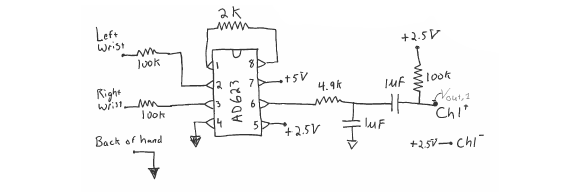

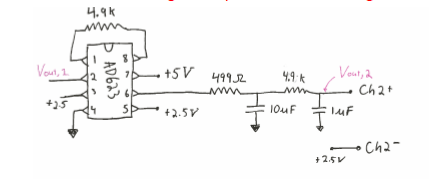

### Model 1:

#### Assumptions: 

- We model the input heart rate is a cosine wave
- There is no electrical interference
- We do not include the input impedence of the analog discovery, which is used to measure output voltage

Below we set the input signal frequency similar to the frequency of the average heart rate.  This data is taken from the Cleavlend Clinic, https://my.clevelandclinic.org/health/diagnostics/17402-pulse--heart-rate, which states the average heart rate of an adult to be 60 - 100 beats per minute.  Converted to frequency, in Hz, this is 1 Hz.  

                    ({60 beats / 1 minute} * {1 minute / 60 seconds}) = 1 beat per second => 1 Hz

In [4]:
#Change the input signal frequnecy
input_freq = Params(
    f = 1
)

,values
f,1


We then initialize the first filter's parameters.

In [5]:
params1 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    A = 5,      # volt
    f = input_freq.f,   # Hz
    vin = 0
)

,values
R,4900.000000
C,0.000001
A,5.000000
f,1.000000
vin,0.000000


We then define a function to make a system object with the input paramters.  This allows us to make system objects by creating new parameter objects. 

In [6]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(V_out = 0)
    # Omega is eaual to angular frequency
    omega = 2 * np.pi * input_freq.f
    # Tau is equal to the RC Value
    tau = R * C
    # The cutoff frequnecy shows where the filters take effect
    cutoff = 1 / R / C / 2 / np.pi
    t_end = 4 / input_freq.f
    ts = linspace(0, t_end, 401)
    
    return System(R=R, C=C, A=A, f=input_freq.f,
                  init=init, t_end=t_end, ts=ts,
                  omega=omega, tau=tau, cutoff=cutoff, vin=vin)

In [7]:
# Use params1 to make a system object
system1 = make_system(params1)

,values
R,4900
C,1e-06
A,5
f,1
init,V_out 0 dtype: int64
t_end,4
ts,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07..."
omega,6.28319
tau,0.0049
cutoff,32.4806


We plot the input signal on a chart using the system1 parameters.

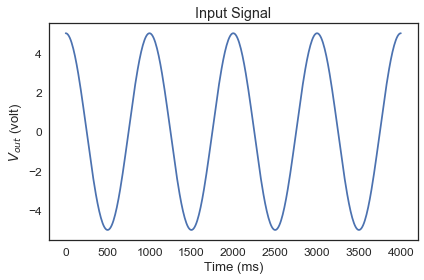

In [8]:
x = linspace(0, system1.t_end * 1000, 401)
v = system1.A * np.cos(2 * pi * (system1.f / 1000) * x)
plt.plot(x, v)
decorate(xlabel='Time (ms)',
             ylabel='$V_{out}$ (volt)',
             title='Input Signal',
             legend=False)

We define a slope function to express the change in voltage across the filter.  This models the effect of the filter based on RC values and the frequency of the input signal.  We run this function with the run_ode_solver.

In [9]:
def slope_func_init(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)"""

    vout = state
    
    unpack(system)
    
    vin = A * np.cos(2 * pi * f * t)
    
    dvoutdt = (vin - vout) / (R * C)
    
    return dvoutdt

In [10]:
# Run system1 through slope_func_init using the run_ode_sovler
results1, details1 = run_ode_solver(system1, 
                                    slope_func_init, 
                                    t_eval=system1.ts)

In [11]:
def plot_results(results):
    """Makes function to plot the results given in a DataFrame.
    
    results: DataFrame of the results of 
             run_ode_solver on a slope function
    
    returns: a plot of the results"""
    
    xs = results.V_out.index
    ys = results.V_out.values

    t_end = get_last_label(results)
    if t_end < 10:
        xs *= 1000
        xlabel = 'Time (ms)'
    else:
        xlabel = 'Time (s)'
        
    plot(xs, ys)
    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)',
             legend=False)

We then set the parameters of the second filter and make a system of these values.

In [12]:
params2 = Params(
    R = 100e3,   # ohm
    C = 1e-6,  # farad
    vin = results1.V_out
)

,values
R,100000
C,1e-06
vin,0.00 0.000000 0.01 4.346388 0.02 4.89...


In [13]:
system2 = make_system(params2)

,values
R,100000
C,1e-06
A,5
f,1
init,V_out 0 dtype: int64
t_end,4
ts,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07..."
omega,6.28319
tau,0.1
cutoff,1.59155


We create a slope function that models a high pass filter.

In [14]:
def slope_func_high_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    unpack(system)
    
    vin1 = A * np.cos(2 * pi * f * t)
    
    #vin = interpolate(system.vin)
    
    dvindt = (vin1 - vout) / (R * C)
    
    dvoutdt = dvindt - ((vout) / (R * C))
    
    return dvoutdt

We create a slope function that models a low pass filter.

In [15]:
def slope_func_low_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    vin = interpolate(system.vin)
    
    dvoutdt = (vin(t) - vout) / (system.R * system.C)
    
    return dvoutdt

We test both the high pass and low pass filter slope functions using the same system object.  We expect the results to be different with the same input frequency.

In [70]:
test_system = make_system(params1)

,values
R,4900
C,1e-06
A,5
f,50
init,V_out 0 dtype: int64
t_end,0.08
ts,"[0.0, 0.0002, 0.0004, 0.0006000000000000001, 0..."
omega,314.159
tau,0.0049
cutoff,32.4806


In [71]:
test_results1, test_details1 = run_ode_solver(example_system, 
                                              slope_func_high_pass, 
                                              t_eval=test_system.ts)

In [72]:
test_results2, test_details2 = run_ode_solver(example_system, 
                                                    slope_func_init, 
                                                    t_eval=test_system.ts)

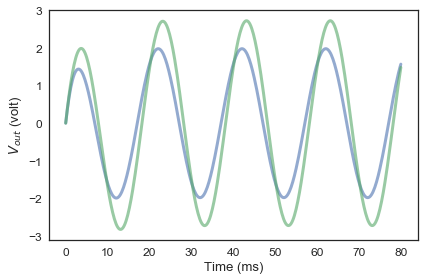

In [73]:
plot_results(test_results1)
plot_results(test_results2)

The second filter is a high pass filter, and thus, we are able to use the run_ode_solver function with the second set of parameters and the high pass filter slope function.

In [16]:
results2, details2 = run_ode_solver(system2, 
                                    slope_func_high_pass, 
                                    t_eval=system2.ts)

We then set the third filter's parameters and use them to make a system for the third filter.

In [17]:
params3 = Params(
    R = 499,   # ohm
    C = 10e-6,  # farad
    vin = results2.V_out
)

,values
R,499
C,1e-05
vin,0.00 0.000000 0.01 0.452860 0.02 0.82...


In [18]:
system3 = make_system(params3)

,values
R,499
C,1e-05
A,5
f,1
init,V_out 0 dtype: int64
t_end,4
ts,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07..."
omega,6.28319
tau,0.00499
cutoff,31.8948


The third and fourth filters used are low pass filters.  Thus, we use the same process with the low pass filter slope function for these filters.

In [19]:
results3, details3 = run_ode_solver(system3, 
                                    slope_func_low_pass, 
                                    t_eval=system3.ts)

We set the fourth filter's parameters and then use them to make a system for the fourth filter.

In [20]:
params4 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    vin = results3.V_out
)

,values
R,4900
C,1e-06
vin,0.00 0.000000 0.01 0.257302 0.02 0.63...


In [21]:
system4 = make_system(params4)

,values
R,4900
C,1e-06
A,5
f,1
init,V_out 0 dtype: int64
t_end,4
ts,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07..."
omega,6.28319
tau,0.0049
cutoff,32.4806


In [22]:
results4, details4 = run_ode_solver(system4, 
                                    slope_func_low_pass, 
                                    t_eval=system4.ts)

### Results 1:

We plot the results of all of the filters on the same chart.

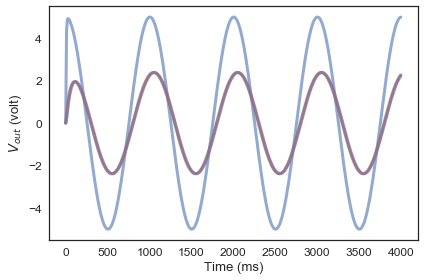

In [23]:
plot_results(results1)
plot_results(results2)
plot_results(results3)
plot_results(results4)

We then plot the input signal and the output signal to compare the attenuation through the circuit.

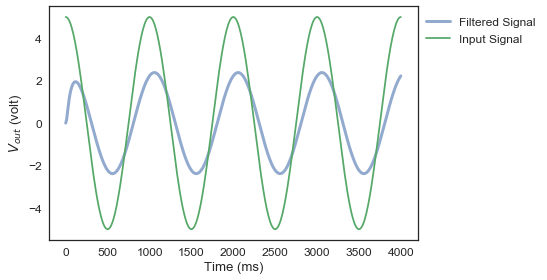

In [24]:
#plt.xkcd()
plot_results(results4)
plt.plot(x, v)
plt.legend(["Filtered Signal", "Input Signal"], 
           loc='upper right', bbox_to_anchor=(1.35, 1))

### Model 2:

We define a function that determines the amplification of the AD623 integrated circuit used.  This value is expressed through the equation, 

                                            G = (1+ (100 k ohms/Rg))

Where Rg is the resistor across pins 1 and 8.

In [25]:
def amp(R):
    """Makes function to determine the gain of the AD623 amplifier.
    
    R: The reststance value across pins 1 and 8 on this chip
    
    returns: The gain of the amplifier
    """
    G = 1 + (100e3/R)
    return G

We find the gain for both amplifers.  G1 expresses the gain of the first chip, and G2 expresses the gain of the second chip.

In [26]:
G1 = amp(2e3)
G2 = amp(4.9e3);

We set the parameters of all the resisters and capacitors in the circuit, which we then use in a function that runs the entire circuit simulation.

In [27]:
run_sim_system = System(R1 = 4.9e3, # ohm
                        C1 = 1e-6,  # farad 
                        A = 5 * G1, # volt
                        f = input_freq.f,   # Hz 
                        vin = 0, 
                        R2 = 100e3,   # ohm
                        C2 = 1e-6,  # farad
                        R3 = 499,   # ohm
                        C3 = 10e-6,  # farad
                        R4 = 4.9e3,   # ohm
                        C4 = 1e-6  # farad
                        )

,values
R1,4900.000000
C1,0.000001
A,255.000000
f,1.000000
vin,0.000000
R2,100000.000000
C2,0.000001
R3,499.000000
C3,0.000010
R4,4900.000000


We define a function that runs through the entire simiulation using the fuctions defined in Model 1 and the paramters defined above.

In [28]:
def run_sim(input_freq, make_system, 
            slope_func_init, slope_func_high_pass, 
            slope_func_low_pass, G1, G2, system):
    
    """Define a function that runs the enitre circuit simulation
    
    inputs
        input_freq: the input signal frequency
        make_system: function that takes parameters and returns a system
        slope_func_init: used to model the first filter
        slope_func_high_pass: used to model high pass filters
        slope_func_low_pass: used to model low pass filters
        G1: the gain of the first amplifier
        G2: the gain of the second amplifier
        system: the parameters of the circuit
    
    returns
        results5: the output of the first filter
        results6: the output of the second filter
        results7: the output of the thrid filter
        results8: the output of the fourth filter
        ratio: the ratio of input signal amplitude to ourput signal amplitude
    """
    
    params5 = Params(
    R = system.R1,   
    C = system.C1,  
    A = system.A,      
    f = system.f,   
    vin = system.vin
    )
    
    system5 = make_system(params5)
    results5, details5 = run_ode_solver(system5, 
                                        slope_func_init, 
                                        t_eval=system5.ts)
    
    params6 = Params(
    R = system.R2,
    C = system.C2,
    vin = results5.V_out
    )
    
    system6 = make_system(params6)
    results6, details6 = run_ode_solver(system6, 
                                        slope_func_high_pass, 
                                        t_eval=system6.ts)
    
    params7 = Params(
    R = system.R3,
    C = system.C3,
    vin = results6.V_out * G2
    )
    
    system7 = make_system(params7)
    results7, details7 = run_ode_solver(system7, 
                                        slope_func_low_pass, 
                                        t_eval=system7.ts)
    
    params8 = Params(
    R = system.R4,
    C = system.C4,
    vin = results7.V_out
    )
    
    system8 = make_system(params8)
    results8, details8 = run_ode_solver(system8, 
                                        slope_func_low_pass, 
                                        t_eval=system8.ts)
    
    A_in = params5.A
    
    A_out=(results8.V_out.max()-results8.V_out.min())/2
        
    ratio = A_out/A_in
    
    return State(results5=results5, 
                 results6=results6, 
                 result7=results7, 
                 results8=results8, 
                 ratio=ratio)

We set the input frequency to 50 Hz, to test the circuit at high frequencies.  We do this to confirm that each of the filters are working as there is an apparent difference in the outputs of each filter.

In [29]:
input_freq.f = 50

In [30]:
results5, results6, results7, results8, ratio = run_sim(input_freq, 
                                                        make_system, 
                                                        slope_func_init, 
                                                        slope_func_high_pass, 
                                                        slope_func_low_pass, 
                                                        G1, G2, run_sim_system)

### Results 2:

The simualtion is run with an input frequency of 50 Hz to show that each of the filters are working.  We can see that much of the high frequency is filtered out.

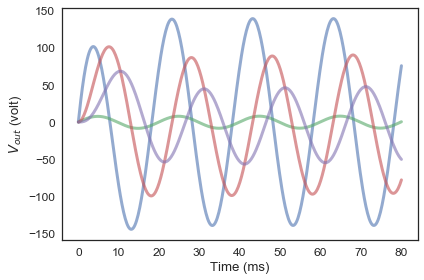

In [31]:
plot_results(results5)
plot_results(results6)
plot_results(results7)
plot_results(results8)

### Interpretation:

We sweep the input signal frequencies to create a Bode Plot of the system.  We are able to compare the results of our simualted model to the experimental data.

In [32]:
sweep = SweepSeries()
for f in linspace(1, 100, 50):
    input_freq.f=f
    state = run_sim(input_freq, make_system, 
                    slope_func_init, 
                    slope_func_high_pass, 
                    slope_func_low_pass, 
                    G1, G2, run_sim_system).ratio
    sweep[f] = state;

We plot the results of our simulated Bode Plot with frequencies swept from 1 Hz to 100 Hz.

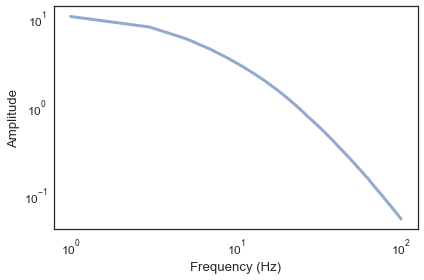

In [33]:
plot(sweep)
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log')

We import the exerimental data.

In [34]:
from pandas import read_csv
data = read_csv("Bode Plot Data Two Channel Adjusted.csv")
data.columns = ["Frequency", "Channel1", "Channel2"]
print(data)

    Frequency  Channel1   Channel2
0    1.204622  1.336704   7.892721
1    1.394753  2.062281   7.447578
2    1.614894  2.720442   6.957306
3    1.869782  3.309978   6.506548
4    2.164899  3.832494   6.041254
5    2.506597  4.289950   5.543557
6    2.902226  4.685360   5.103302
7    3.360299  5.021772   4.687570
8    3.890673  5.305573   4.287470
9    4.504759  5.534682   3.906275
10   5.215768  5.710039   3.533519
11   6.039000  5.834386   3.155440
12   6.992167  5.909790   2.756838
13   8.095778  5.936137   2.324386
14   9.373577  5.912632   1.843787
15  10.853058  5.834932   1.306494
16  12.566053  5.702385   0.701586
17  14.549419  5.513495   0.023472
18  16.845831  5.264004  -0.726697
19  19.504696  4.946740  -1.541431
20  22.583225  4.554394  -2.408142
21  26.147654  4.080540  -3.317242
22  30.274676  3.520765  -4.257796
23  35.053087  2.875092  -5.225047
24  40.585699  2.145339  -6.203025
25  46.991553  1.336644  -7.194759
26  54.408477  0.455705  -8.204307
27  62.996052 -0.488

In [35]:
def plot_data(data):
    """We define a function that plots the Bode Plot data
    
    data: the experimental results
    
    returns: a Bode Plot of experimental data
    """
    f = (data.Frequency)
    a = (data.Channel2)
       
    plot(f, a)
    decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log',
             title='Bode Plot Collected Data',
             legend=False)

We plot the experimental results.

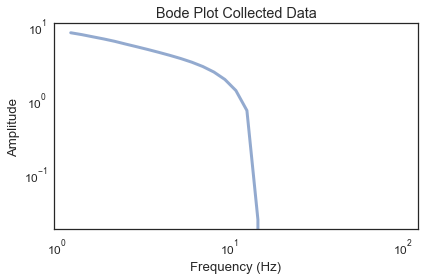

In [36]:
plot_data(data)

The experimental and theoretical results are graphed on the same plot.  We can see that the experimental results show more harsh attenutation near the cutoff frequnecy; whereas, the theoretical results have a much more shallow cutoff.

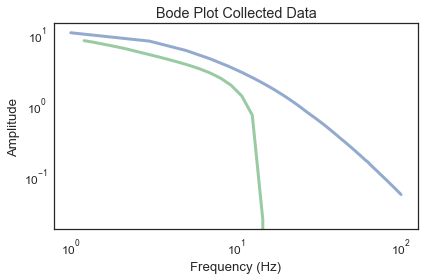

In [37]:
plot(sweep)
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             title='Bode Plot Simulated VS Collected Data')
plot_data(data)

### Model 3:

We create parameters to determine how the model wll respond to various changes in R and C values.

In [42]:
input_freq.f = 1

These are the first set of R and C values we tested.

In [43]:
run_sim_system2 = System(R1 = 3.01e4, # ohm
                         C1 = 1e-6,  # farad 
                         A = 5 * G1, # volt
                         f = input_freq.f,   # Hz 
                         vin = 0, 
                         R2 = 1e5,   # ohm
                         C2 = 3.3e-6,  # farad
                         R3 = 1e6,   # ohm
                         C3 = 1e-7,  # farad
                         R4 = 4.99e3,   # ohm
                         C4 = 1e-5  # farad
                        )

,values
R1,3.010000e+04
C1,1.000000e-06
A,2.550000e+02
f,1.000000e+00
vin,0.000000e+00
R2,1.000000e+05
C2,3.300000e-06
R3,1.000000e+06
C3,1.000000e-07
R4,4.990000e+03


In [44]:
results5, results6, results7, results8, ratio = run_sim(input_freq, 
                                                        make_system, 
                                                        slope_func_init, 
                                                        slope_func_high_pass, 
                                                        slope_func_low_pass, 
                                                        G1, G2, run_sim_system2)

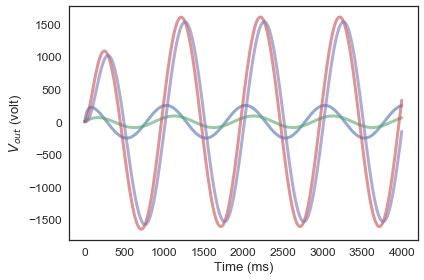

In [45]:
plot_results(results5)
plot_results(results6)
plot_results(results7)
plot_results(results8)

In [46]:
sweep2 = SweepSeries()
for f in linspace(1, 50, 50):
    input_freq.f=f
    state = run_sim(input_freq, make_system, 
                    slope_func_init, 
                    slope_func_high_pass, 
                    slope_func_low_pass, 
                    G1, G2, run_sim_system2).ratio
    sweep2[f] = state;

These are the second set of R and C values we tested.

In [47]:
run_sim_system3 = System(R1 = 604, # ohm
                         C1 = 1e-4,  # farad 
                         A = 5 * G1, # volt
                         f = input_freq.f,   # Hz 
                         vin = 0, 
                         R2 = 1.58e3,   # ohm
                         C2 = 1e-4,  # farad
                         R3 = 604,   # ohm
                         C3 = 1e-4,  # farad
                         R4 = 604,   # ohm
                         C4 = 1e-4  # farad
                        )

,values
R1,604.0000
C1,0.0001
A,255.0000
f,50.0000
vin,0.0000
R2,1580.0000
C2,0.0001
R3,604.0000
C3,0.0001
R4,604.0000


In [48]:
results5, results6, results7, results8, ratio = run_sim(input_freq, 
                                                        make_system, 
                                                        slope_func_init, 
                                                        slope_func_high_pass, 
                                                        slope_func_low_pass, 
                                                        G1, G2, run_sim_system3)

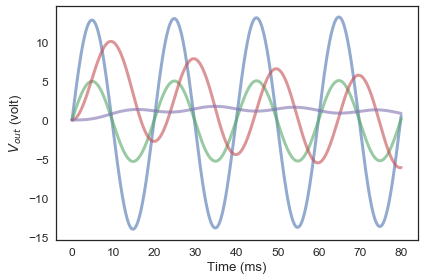

In [49]:
plot_results(results5)
plot_results(results6)
plot_results(results7)
plot_results(results8)

In [50]:
sweep3 = SweepSeries()
for f in linspace(1, 50, 50):
    input_freq.f=f
    state = run_sim(input_freq, make_system, 
                    slope_func_init, 
                    slope_func_high_pass, 
                    slope_func_low_pass, 
                    G1, G2, run_sim_system3).ratio
    sweep3[f] = state;

These are the third set of R and C values we tested.

In [51]:
run_sim_system4 = System(R1 = 4.99e3, # ohm
                         C1 = 1e-6,  # farad 
                         A = 5 * G1, # volt
                         f = input_freq.f,   # Hz 
                         vin = 0, 
                         R2 = 1.58e3,   # ohm
                         C2 = 1e-4,  # farad
                         R3 = 2.00e4,   # ohm
                         C3 = 1e-6,  # farad
                         R4 = 4.9e4,   # ohm
                         C4 = 1e-6  # farad
                        )

,values
R1,4990.000000
C1,0.000001
A,255.000000
f,50.000000
vin,0.000000
R2,1580.000000
C2,0.000100
R3,20000.000000
C3,0.000001
R4,49000.000000


In [52]:
results5, results6, results7, results8, ratio = run_sim(input_freq, 
                                                        make_system, 
                                                        slope_func_init, 
                                                        slope_func_high_pass, 
                                                        slope_func_low_pass, 
                                                        G1, G2, run_sim_system4)

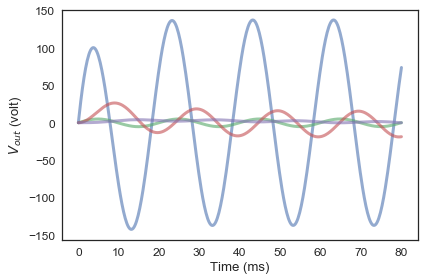

In [53]:
plot_results(results5)
plot_results(results6)
plot_results(results7)
plot_results(results8)

In [54]:
sweep4 = SweepSeries()
for f in linspace(1, 50, 50):
    input_freq.f=f
    state = run_sim(input_freq, make_system, 
                    slope_func_init, 
                    slope_func_high_pass, 
                    slope_func_low_pass, 
                    G1, G2, run_sim_system4).ratio
    sweep4[f] = state;

### Results 3: 

With the changes in R and C values, the input signal will attenuate differently.  We then passed various frequnecies through the modeled circuit to create a Bode Plot.  A comparison of the Bode plots are shown below.

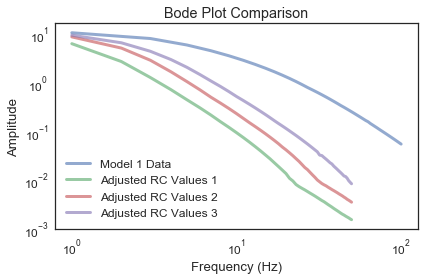

In [58]:
plot(sweep, label = 'Model 1 Data')
plot(sweep2, label = 'Adjusted RC Values 1')
plot(sweep3, label = 'Adjusted RC Values 2')
plot(sweep4, label = 'Adjusted RC Values 3')
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log',
             title='Bode Plot Comparison')

### Interpretation:

The response of the circuit to different cutoff frequencies can be seen in the Bode plots above. As the cutoff frequency of the high pass filter increases, the Bode Plot line becomes more shallow, and as the cutoff frequnecy of the low pass filters increases, the y-intercept of the Bode Plot decreases.

A few of the drawbacks with our model are that the high pass slope function can only be used if there is only one high pass filter and it is comes after the first low pass filter, we do not model electrical interference, and we use a cosine wave to model the input signal.  We know that a heartbeat is not a cosine wave, and thus, we are unsure as to whether a heart signal would work with this model.

We wrote various functions in attempts to best fit our model, and stuck with the ones that worked.  We also varied RC and frequency values to determine if our model was functioning the way we anticipated. 

### Abstract:

The question we addressed was, how does this circuit respond with changes in RC values?  The response of the circuit to different cutoff frequencies can be seen in the Bode plots above. As the cutoff frequency of the high pass filter increases, the Bode Plot line becomes more shallow, and as the cutoff frequnecy of the low pass filters increases, the y-intercept of the Bode Plot decreases.  Using the initial circuit, we can see that the output signal will always be attenuated; however, the extent of the attenuation depends on frequency and the cutoff frequencies of the filters.

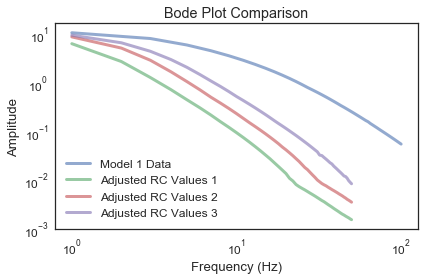

In [61]:
plot(sweep, label = 'Model 1 Data')
plot(sweep2, label = 'Adjusted RC Values 1')
plot(sweep3, label = 'Adjusted RC Values 2')
plot(sweep4, label = 'Adjusted RC Values 3')
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log',
             title='Bode Plot Comparison')